<a href="https://colab.research.google.com/github/sandhrabijoy/_/blob/master/Pytorch_understanding_pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:10<00:00, 903kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.0MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32, 10])


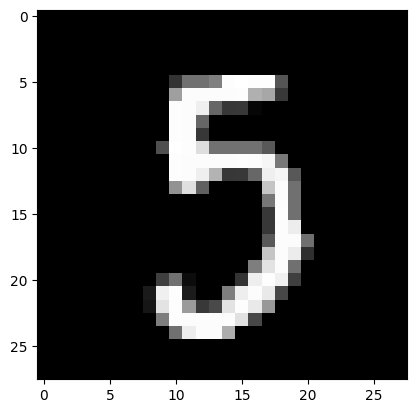

Label: 5
Epoch 1/5, Loss: 0.2054
Epoch 2/5, Loss: 0.0737
Epoch 3/5, Loss: 0.0601
Epoch 4/5, Loss: 0.0514
Epoch 5/5, Loss: 0.0430
Training complete!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


class MNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.unsqueeze(1).float().to(device)
        self.y = F.one_hot(y, num_classes=10).float().to(device)
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create Dataloaders
train_dataset = MNISTDataset(trainset.data, trainset.targets)
test_dataset = MNISTDataset(testset.data, testset.targets)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)


train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Display a sample image
img = train_features[0].squeeze().cpu()
label = train_labels[0].cpu()
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label.argmax().item()}")

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)

        # Placeholder for fc1 input size (to be computed later)
        self.flattened_size = None

        # Fully connected layers
        self.fc1 = nn.Linear(1, 1)  # Placeholder (will update after computing dynamically)
        self.fc2 = nn.Linear(1200, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)


        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 1200).to(x.device)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x


# Initialize model
model = MyModel().to(device)

loss_fn = nn.CrossEntropyLoss()  # Softmax automatically applied in loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch.argmax(dim=1))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

print("Training complete!")
